In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

TensorFlow 2.x selected.
Tensorflow version: 2.0.0
GPU: /device:GPU:0


In [0]:
!git clone https://github.com/michalovsky/books-data.git

Cloning into 'books-data'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 20), reused 57 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [0]:
import glob

def read_data(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books-data/kafka/"
directory2 = "books-data/shelley/"
directory3 = "books-data/defoe/"
directory4 = "books-data/plato/"

text = read_data(directory1)
print ('Length of text: {} characters'.format(len(text)))

Length of text: 571642 characters


In [0]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove, chars_to_translate, replacement_chars):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = " ".join(text.split())
		return text

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

vocab = sorted(list(set(text)))
print ('{} unique characters:'.format(len(vocab)))
print(vocab)
vocab_size = len(vocab)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

char_to_indices = dict((c, i) for i, c in enumerate(vocab))
indices_to_char = dict((i, c) for i, c in enumerate(vocab))

class Dataset:
  def __init__(self):
    self.text_sequences = list()
    self.X_train = list()
    self.y_train = list()
    self.X_val = list()
    self.y_val = list()

  def make_dataset(self, text, sequence_length=40):
    sequences = list()
    labels = list()
    encoded_chars = np.array([char_to_indices[ch] for ch in text]) 
    for i in range(0, len(encoded_chars) - sequence_length, 1):
        sequences.append(encoded_chars[i:i + sequence_length])
        self.text_sequences.append(text[i:i + sequence_length])
        labels.append(encoded_chars[i + sequence_length])
    X = np.reshape(sequences, (len(sequences), sequence_length, 1))
    X = np_utils.to_categorical(X)
    y = np_utils.to_categorical(labels)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
    return self

  def get_random_sequence(self):
	  return self.text_sequences[randint(0, len(self.text_sequences))]

input_sequence_length = 40
dataset = Dataset().make_dataset(text, input_sequence_length)

Using TensorFlow backend.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model.add(LSTM(90, input_shape=(input_sequence_length, vocab_size),return_sequences=True, recurrent_initializer='glorot_uniform'))
    self.model.add(LSTM(90, recurrent_initializer='glorot_uniform'))
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 90)            43200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dense (Dense)                (None, 29)                2639      
Total params: 110,999
Trainable params: 110,999
Non-trainable params: 0
_________________________________________________________________


In [0]:
import sys

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(model, seed, characters_amount=100):
    print('Generating with seed: "' + seed + '"')
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('Diversity:', diversity)
        sentence = seed
        generated = ''
        generated += sentence
        sys.stdout.write(generated)

        for i in range(characters_amount):
            x_pred = np.zeros((1, input_sequence_length, vocab_size))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_indices[char]] = 1.
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_to_char[next_index]
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            if next_char=='.':
              sys.stdout.write("\n")
            sys.stdout.flush()
        print()


In [0]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    generate_text(model.model, seed=seed_for_epochs, characters_amount=100)
    print()

text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)

Checking with seed: ed permission again from mr. samsa for h


In [0]:
batch_size = 100
epochs = 100
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_val, dataset.y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 447012 samples, validate on 111754 samples

Generating with seed: "ed permission again from mr. samsa for h"
Diversity: 0.2
ed permission again from mr. samsa for his said the canter to the can the storged to his had the still the painter the stort the stort the s
Diversity: 0.5
ed permission again from mr. samsa for he ont and the storg be, was inte and the made to sile the sald as in the stert to canted of hand pro
Diversity: 1.0
ed permission again from mr. samsa for hispeffrad to fir hand.
 all to some on the wime on.
 the expriacts not saicht.
 weytnes som fires befwi
Diversity: 1.2
ed permission again from mr. samsa for had illardy hirs.
 on.
 i aswe fill of peut of you no tillet to gent my.
 agfosedssed as beconigingly mi

447012/447012 - 69s - loss: 2.0066 - accuracy: 0.4114 - val_loss: 1.7154 - val_accuracy: 0.4888


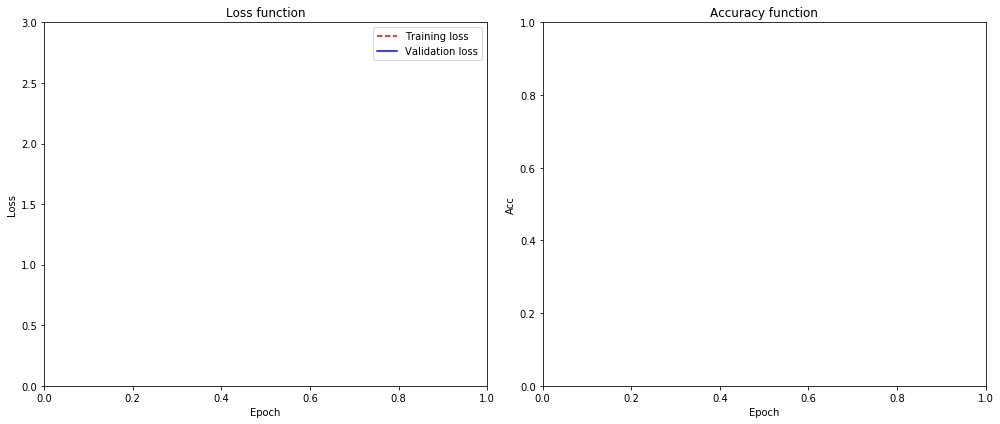

In [0]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [0]:
seed = dataset.get_random_sequence()
print("Generating with seed:", seed, "\n")
generate_text(model.model, seed, characters_amount=200)

Generating with seed: d there was also, somewhere in front of  

Generating with seed: "d there was also, somewhere in front of "
Diversity: 0.2
d there was also, somewhere in front of the could the stind of the still the still the staint and the stort and the stort the stort the cantion the stort the can the stort the stort the said the can the stort the stort the cant to him the s
Diversity: 0.5
d there was also, somewhere in front of not his and his was me have suppreation and of his still beant he said the cant her stort that be some proaally in the storn sto live becint that standed and some in the dident he said was all and and
Diversity: 1.0
d there was also, somewhere in front of himpany with in allmipe and sulrood.
 me tho his lakitusion non they mevers of.
 the liprereffend fan lepomy.
 ble one say here higher as he handaly buss.
 he seworgsred untiid him hid houd you might prie
Diversity: 1.2
d there was also, somewhere in front of a sat, streprby daly of herse.
 soppredsps,